# Integrating scATAC-seq data using SCALEX

The following tutorial demonstrates how to use SCALEX for *integrating* scATAC-seq data. 

There are two parts of this tutorial:

* **Seeing the batch effect.** This part will show the batch effects of two adult mouse brain datasets from single nucleus ATAC-seq (snATAC) and droplet-based platform (Mouse Brain 10X) that used in SCALEX manuscript.
* **Integrating data using SCALEX.** This part will show you how to perform batch correction using [SCALEX](https://scalex.readthedocs.io/en/latest/api/scalex.SCALEX.html#scalex.SCALEX) function in SCALEX.

In [1]:
import scalex
from scalex.function import SCALEX
from scalex.plot import embedding
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import episcanpy as epi

In [2]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
sns.__version__

'0.10.1'

In [4]:
scalex.__version__

'0.2.0'

## Seeing the batch effect

The following data has been used in the [SnapATAC](https://www.nature.com/articles/s41467-021-21583-9) paper, has been used here, and can be downloaded from [here](http://zhanglab.net/scalex-tutorial/mouse_brain_atac.h5ad).

On a unix system, you can uncomment and run the following to download the count matrix in its anndata format.

In [5]:
# ! wget http://zhanglab.net/scalex-tutorial/mouse_brain_atac.h5ad

In [6]:
adata_raw=sc.read('mouse_brain_atac.h5ad') 
adata_raw

AnnData object with n_obs × n_vars = 13746 × 479127
    obs: 'batch'

Inspect the batches contained in the dataset.

In [7]:
adata_raw.obs.batch.value_counts()

snATAC    9646
10X       4100
Name: batch, dtype: int64

The data processing procedure is according to the epiScanpy tutorial [[Buenrostro_PBMC_data_processing]](https://nbviewer.jupyter.org/github/colomemaria/epiScanpy/blob/master/docs/tutorials/Buenrostro_PBMC_data_processing.html).

In [8]:
epi.pp.filter_cells(adata_raw, min_features=1)
epi.pp.filter_features(adata_raw, min_cells=5)
adata_raw.raw = adata_raw
adata_raw = epi.pp.select_var_feature(adata_raw,
                                      nb_features=30000,
                                      show=False,copy=True)
adata_raw.layers['binary'] = adata_raw.X.copy()
epi.pp.normalize_total(adata_raw)
adata_raw.layers['normalised'] = adata_raw.X.copy()
epi.pp.log1p(adata_raw)
epi.pp.lazy(adata_raw)
epi.tl.leiden(adata_raw)

filtered out 11140 genes that are detected in less than 5 cells
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:01:46)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:35)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


We observe a batch effect.

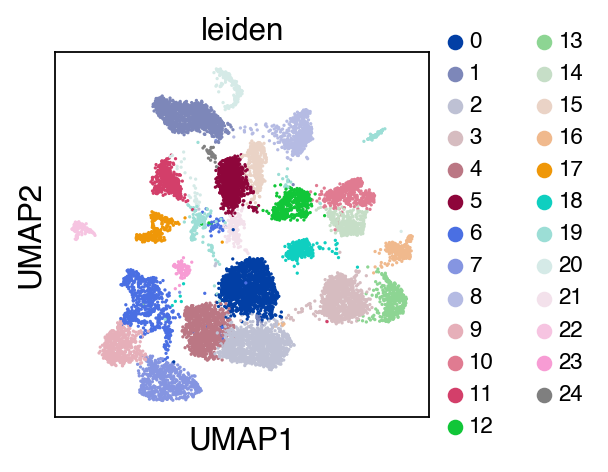

In [9]:
sc.pl.umap(adata_raw,color=['leiden'],legend_fontsize=10)

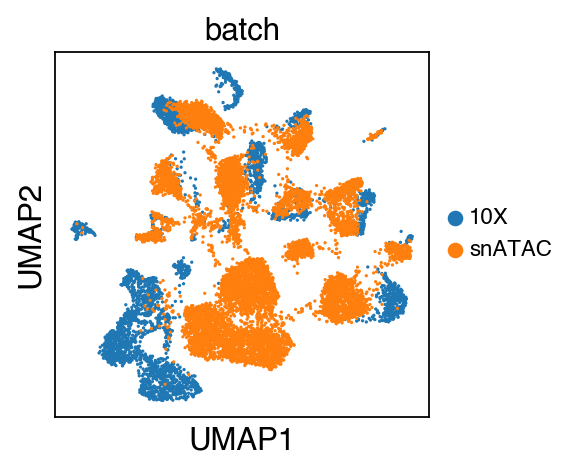

In [10]:
sc.pl.umap(adata_raw,color=['batch'],legend_fontsize=10)

In [11]:
adata_raw

AnnData object with n_obs × n_vars = 13746 × 30076
    obs: 'batch', 'nb_features', 'leiden'
    var: 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

## Integrating data using SCALEX

The batch effects can be well-resolved using SCALEX.

<div class="alert alert-info">

**Note**

Here we use GPU to speed up the calculation process, however, you can get the same level of performance only using cpu.    

</div>  

In [12]:
adata=SCALEX('mouse_brain_atac.h5ad',batch_name='batch',profile='ATAC',
            min_features=1, min_cells=5, n_top_features=30000,outdir='ATAC_output/',show=False,gpu=8) 

2021-03-30 20:21:45,161 - root - INFO - Raw dataset shape: (13746, 479127)
2021-03-30 20:21:45,166 - root - INFO - Preprocessing
2021-03-30 20:21:45,639 - root - INFO - Filtering cells
2021-03-30 20:21:47,224 - root - INFO - Filtering features


filtered out 11140 genes that are detected in less than 5 cells


2021-03-30 20:21:49,461 - root - INFO - Finding variable features
2021-03-30 20:21:51,582 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-30 20:21:51,690 - root - INFO - Batch specific maxabs scaling
2021-03-30 20:22:16,926 - root - INFO - Processed dataset shape: (13746, 30076)
2021-03-30 20:22:17,234 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=30076, out_features=1024, bias=True)
          (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
      )
    )
    (mu_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
    (var_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
  )
  (decoder): NN(
    (net): ModuleList(
      (0): Block(
        (fc): Linear(in_features=10, out_features=30076, bias=True)
        (norm): DSBatchNorm(
          (bns): ModuleLi

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [13]:
adata

AnnData object with n_obs × n_vars = 13746 × 30076
    obs: 'batch', 'n_genes', 'leiden'
    var: 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'neighbors', 'umap', 'leiden', 'batch_colors', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

While there seems to be some strong batch-effect in all cell types, SCALEX can integrate them homogeneously.

In [14]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

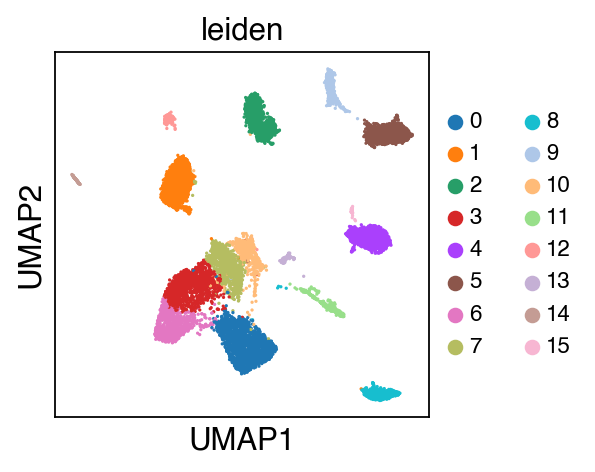

In [15]:
sc.pl.umap(adata,color=['leiden'],legend_fontsize=10)

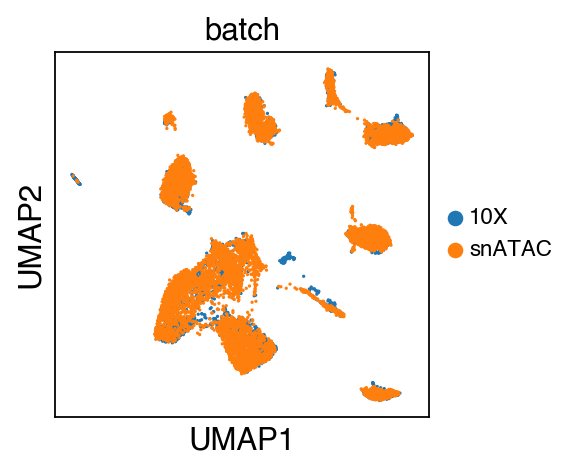

In [16]:
sc.pl.umap(adata,color=['batch'],legend_fontsize=10)

The integrated data is stored as `adata.h5ad` in the output directory assigned by `outdir` parameter in [SCALE](https://scalex.readthedocs.io/en/latest/api/scalex.SCALEX.html#scalex.SCALEX) function. 